#Алгоритм для выявления спам сообщений и текстов

## Установка датасета и библиотек

In [1]:
!pip install transformers

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 14.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [3]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=1e72028703b04c5e11899b908acf8cad28bf20f9f2fc163d86f726b066e274cd
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [4]:
!pip install gensim

In [5]:
!pip3 install -U spacy

In [6]:
!python3 -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 30.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import os

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

#from tqdm.auto import tqdm
from ipywidgets import FloatProgress # RSF
from tqdm import tqdm # RSF

from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk

from collections import Counter
from typing import List
from datasets import Dataset, DatasetDict
from datasets import load_dataset
from sklearn.metrics import roc_auc_score

import re
import nltk

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api

## for sentiment
from textblob import TextBlob
## for ner
import spacy
## for vectorizer
from sklearn import feature_extraction, manifold

import seaborn
seaborn.set(palette='summer')
import string

import transformers

In [9]:
from nltk.tokenize import RegexpTokenizer

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
train_df = pd.read_csv('/content/drive/MyDrive/Spam_classification/train_spam.csv')
train_df['text_type'] = train_df['text_type'].replace(['ham', 'spam'], [0, 1])

In [15]:
train_df.to_csv('/content/drive/MyDrive/Spam_classification/train_spam_changed.csv', index=False)

In [16]:
train_df_orig = pd.read_csv('/content/drive/MyDrive/Spam_classification/train_spam.csv')

In [17]:
train_df

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...
...,...,...
16273,1,if you are interested in binary options tradin...
16274,1,dirty pictureblyk on aircel thanks you for bei...
16275,0,or you could do this g on mon 1635465 sep 1635...
16276,0,insta reels par 80 गंद bhara pada hai 👀 kuch b...


## Обработка данных (EDA)

In [18]:
train_df = train_df.rename(columns={'text_type': 'y'})
train_df.head(5)

,y,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


In [19]:
train_df_orig = train_df_orig.rename(columns={'text_type': 'y'})
train_df_orig.head(5)

,y,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [20]:
print(train_df.shape)

train_df.columns.values

(16278, 2)


array(['y', 'text'], dtype=object)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   y       16278 non-null  int64 
 1   text    16278 non-null  object
dtypes: int64(1), object(1)
memory usage: 254.5+ KB


In [22]:
train_df.y.unique()

array([0, 1])

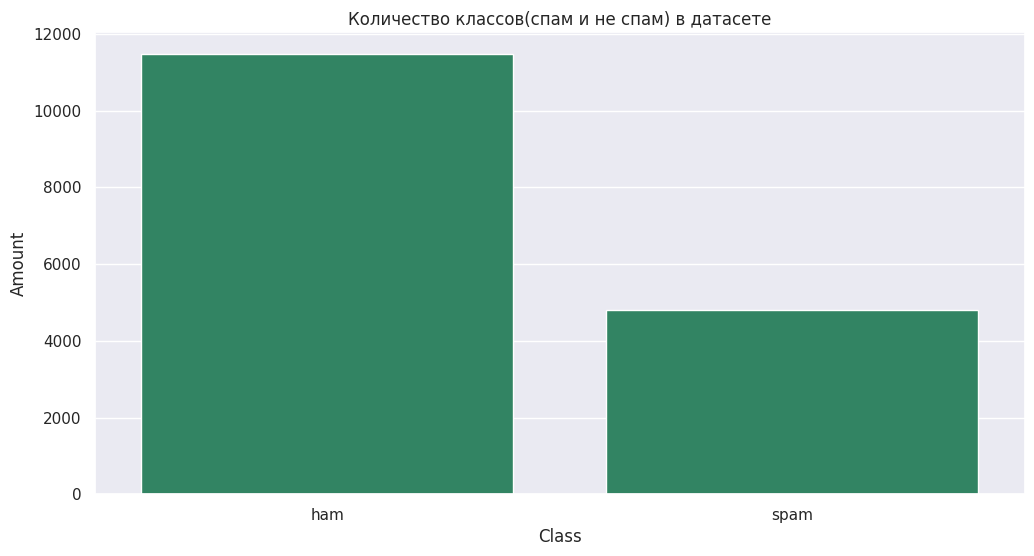

In [23]:
plt.figure(figsize=(12, 6))
g = sns.countplot(x = 'y', data=train_df_orig)
g.set(xlabel='Class', ylabel='Amount', title = "Количество классов(спам и не спам) в датасете")
plt.show()

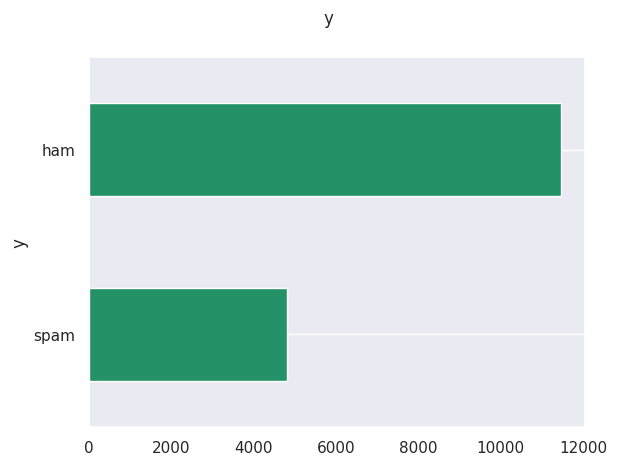

In [24]:
fig, g = plt.subplots()
fig.suptitle("y", fontsize=12)
train_df_orig["y"].reset_index().groupby("y").count().sort_values(by=
       "index").plot(kind="barh", legend=False,
        ax=g).grid(axis='x')
plt.show()

#### Вывод из графиков
На барчартах, на которых представлено количесвто каждого из двух классов, можно заметить сильный дизбаланс классов - не спам сообщений намного больше чем спам сообщений. Это может привести к тому, что моделе будет тяжело распознать спам сообщения, также на это влияет размер датасета.

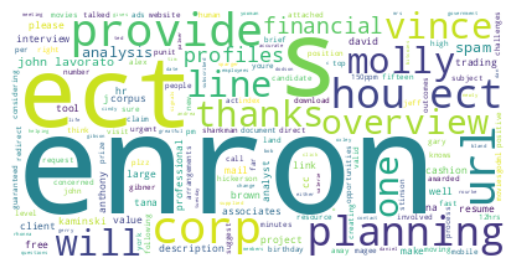

In [25]:
s = pd.Series(train_df.text[0:10], dtype='string')
#Склеиваем пандовскую серию в строку
t = s.str.cat(sep=',')

from wordcloud import WordCloud, STOPWORDS
my_cloud = WordCloud(background_color='white', stopwords=STOPWORDS).generate(t)
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [26]:
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 61.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [27]:
import spacy
from spacy import displacy
import en_core_web_sm

nlp = en_core_web_sm.load()
#тегаем текст
txt = train_df['text'].iloc[0]
doc = nlp(txt)
#выводим результат
displacy.render(doc, style='ent', jupyter=True)

In [28]:
train_df["tags"] = train_df["text"].apply(lambda x: [(tag.text, tag.label_)
                                for tag in nlp(x).ents])

KeyboardInterrupt: 

In [ ]:
train_df['tags']

In [ ]:
import collections

#utils function to count els of a list
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict(
              sorted(dic_counter.items(),
               key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key, value in dic_counter.items()]

    return lst_count

# count tags
train_df['tags'] = train_df['tags'].apply(lambda x: utils_lst_count(x))

#utils function to create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type] * n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]

    else: return 0


# extract features
tags_set = []
for lst in train_df['tags'].tolist():
    for dic in lst:
        for k in dic.keys():
            tags_set.append(k[1])
tags_set = list(set(tags_set))
for features in tags_set:
    train_df['tags' + features] = train_df['tags'].apply(lambda x:
                                                           utils_ner_features(x, features))

train_df.head()

# Препроцессинг текста

In [30]:
dataset = load_dataset('csv', data_files='/content/drive/MyDrive/Spam_classification/train_spam_changed.csv', cache_dir='./')
# test = load_dataset('csv', data_files='/content/drive/MyDrive/ML Стажировки/Vk Spam/data/test_spam.csv', cache_dir='./')
# dataset = DatasetDict({
#     'train': train['train'],
#     'test': test['train']
# })
dataset = dataset['train'].train_test_split(test_size=0.2)

Generating train split: 0 examples [00:00, ? examples/s]

In [31]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text_type', 'text'],
        num_rows: 13022
    })
    test: Dataset({
        features: ['text_type', 'text'],
        num_rows: 3256
    })
})

In [32]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 50

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 13022/13022 [00:14<00:00, 885.46it/s]

Размер словаря: 1663


In [34]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "text_type": self.data[idx]['text_type']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['text_type'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'text_type': labels
    }

    return new_batch

In [35]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 4000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [36]:
def evaluate(model) -> float:
    """
    Calculate accuracy on validation dataloader.
    """
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['text_type'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    roc_auc = roc_auc_score(target.cpu(), predictions.cpu())
    accuracy = (predictions == target).float().mean().item()

    return accuracy, roc_auc

In [37]:
class TokenLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 2,
        aggregation_type: str = 'max',
        rnn_type: str = 'rnn', num_layers=1, dropout=0.1
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        if aggregation_type == "rnn":
            self.rnn = nn.RNN(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        elif aggregation_type == "gru":
            self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        else:
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [38]:
def visualize(loss, acc, roc_auc):
    fig = plt.figure(figsize=(18, 6))

    plt.plot(np.arange(len(loss)), loss, color='blue')
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.show()

    plt.plot(np.arange(len(acc[1:])), acc[1:], color='red')
    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.show()

    plt.plot(np.arange(len(roc_auc)), roc_auc, color='green')
    plt.title('ROC-AUC')
    plt.xlabel("epoch")
    plt.show()

In [39]:
def train_df(model, optimizer, criterion, num_epoch):
    eval_steps = len(train_dataloader) // 2
    losses = []
    accs = []
    roc_aucs = []

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['text_type'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc, roc_auc = evaluate(model)
                accs.append(acc)
                roc_aucs.append(roc_auc)
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))

    return losses, accs, roc_aucs

In [40]:
model = TokenLM(rnn_type = "gru", hidden_dim=256, vocab_size=len(vocab), num_layers=2, dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

Training epoch 4:: 100%|██████████| 407/407 [06:15<00:00,  1.08it/s]


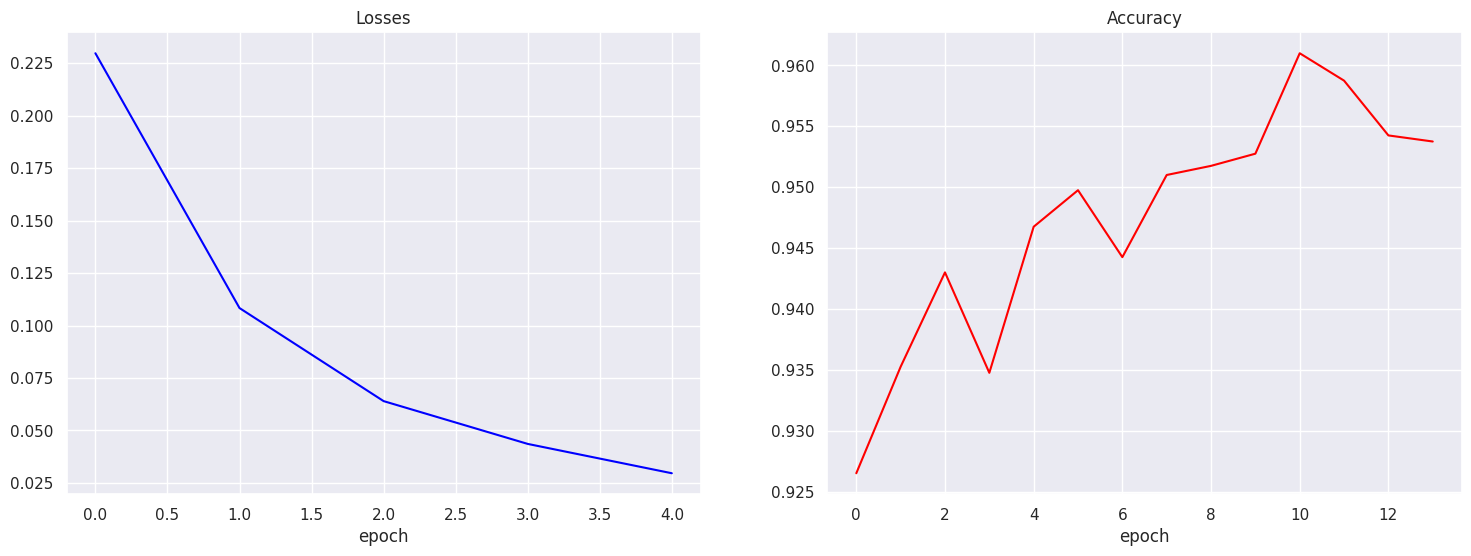

In [ ]:
losses, acc, roc_auc = train_df(model, optimizer, criterion, num_epoch=5)
print(f"Минимальный Loss: {min(losses)}, Максимальный accuracy: {max(acc)}, Максимальный ROC AUC: {max(roc_auc)}")

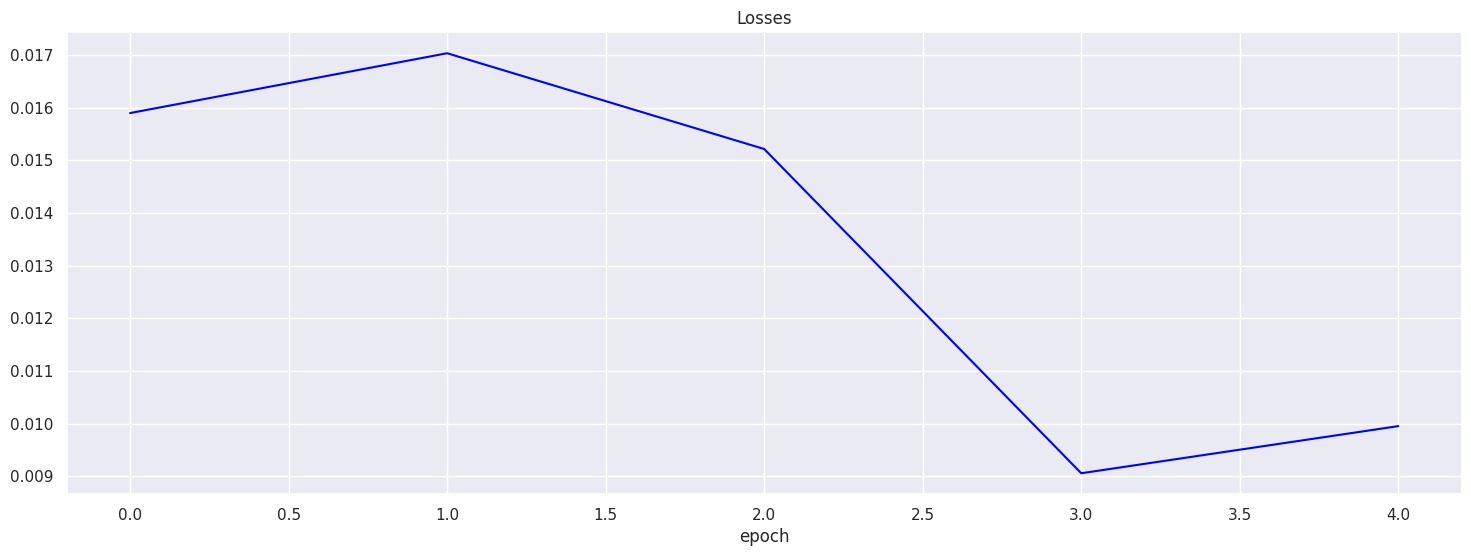

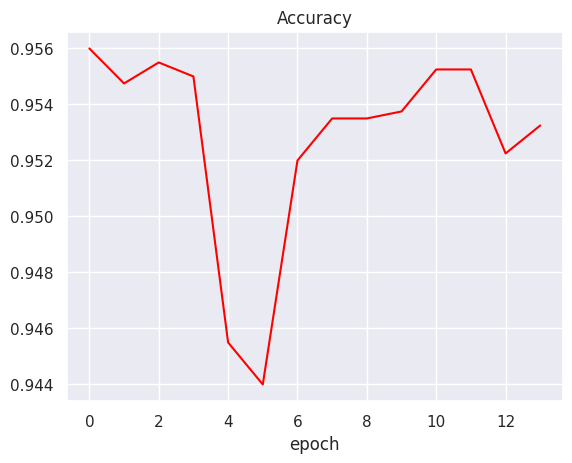

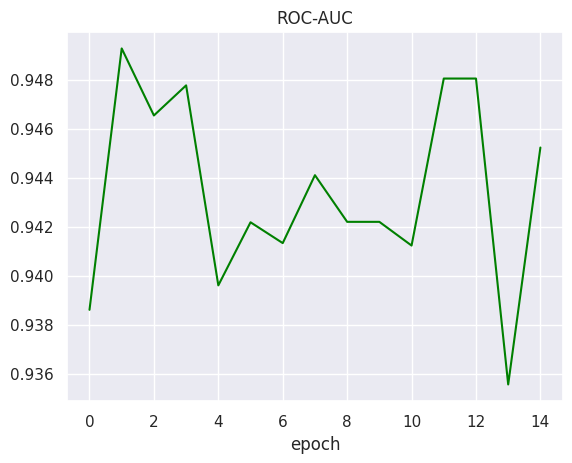

In [ ]:
visualize(losses, acc, roc_auc)

In [ ]:
model = TokenLM(rnn_type = "lstm", hidden_dim=256, vocab_size=len(vocab), num_layers=2, dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

In [ ]:
losses, acc, roc_auc = train_df(model, optimizer, criterion, num_epoch=5)
print(f"\nМинимальный Loss: {min(losses)}, Максимальный accuracy: {max(acc)}, Максимальный ROC AUC: {max(roc_auc)}")

Training epoch 4:: 100%|██████████| 407/407 [00:20<00:00, 20.33it/s]


Минимальный Loss: 0.025036683416283154, Максимальный accuracy: 0.9575000405311584, Максимальный ROC AUC: 0.9457667618876687


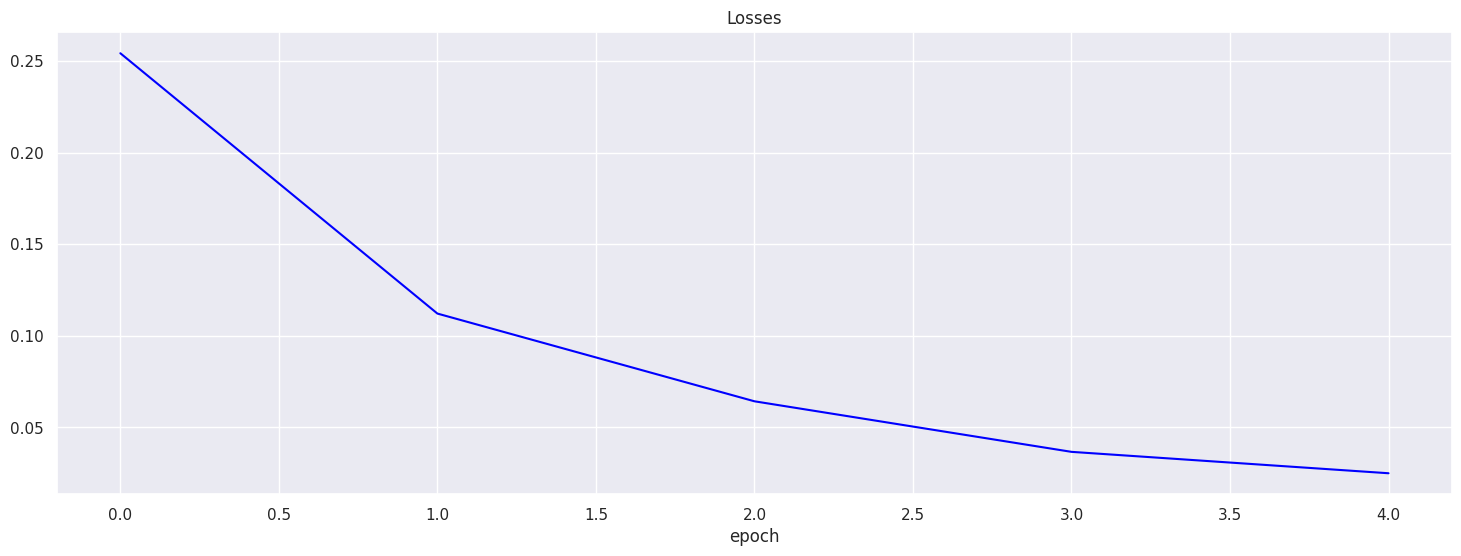

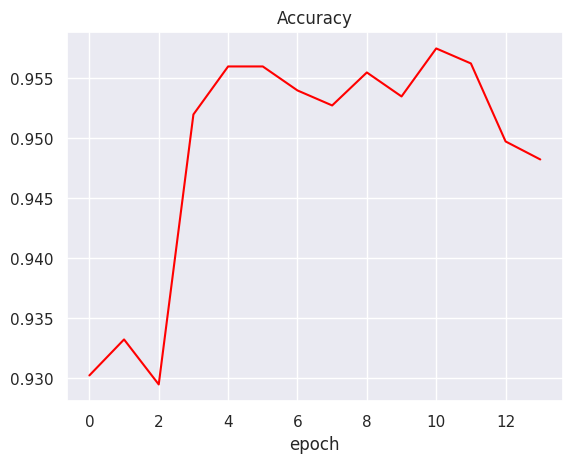

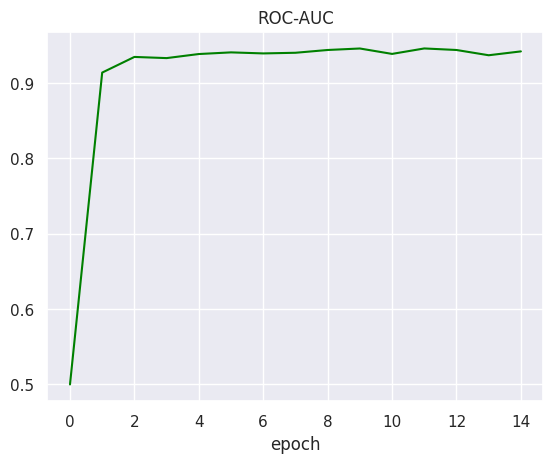

In [ ]:
visualize(losses, acc, roc_auc)

Training epoch 6:: 100%|██████████| 407/407 [00:34<00:00, 11.89it/s]



Минимальный Loss: 0.01280065254300757, Максимальный accuracy: 0.9547500610351562, Максимальный ROC AUC: 0.9464171062249354


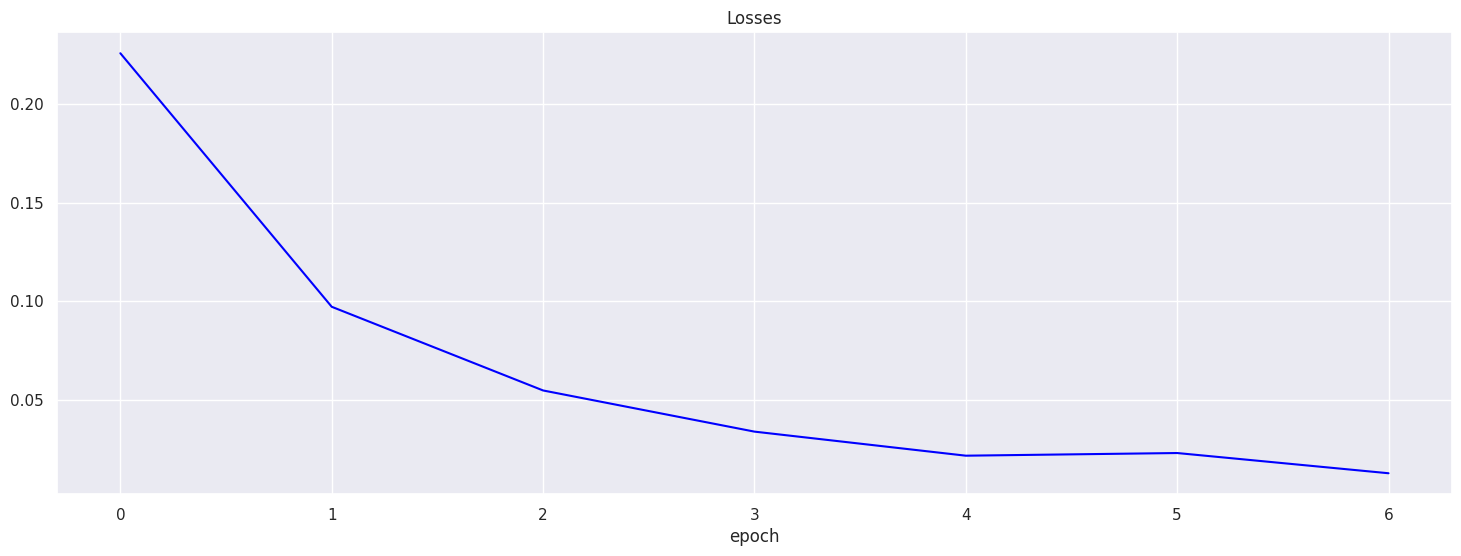

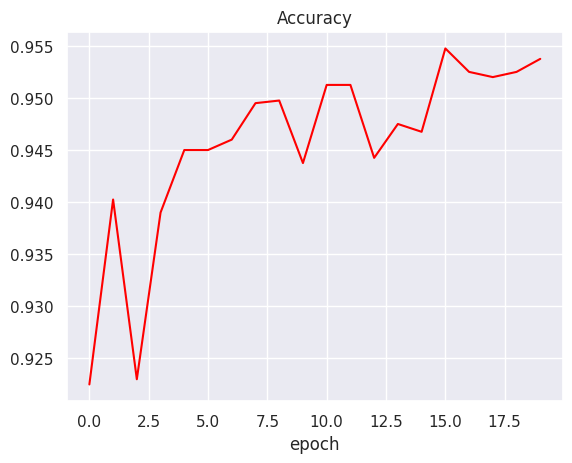

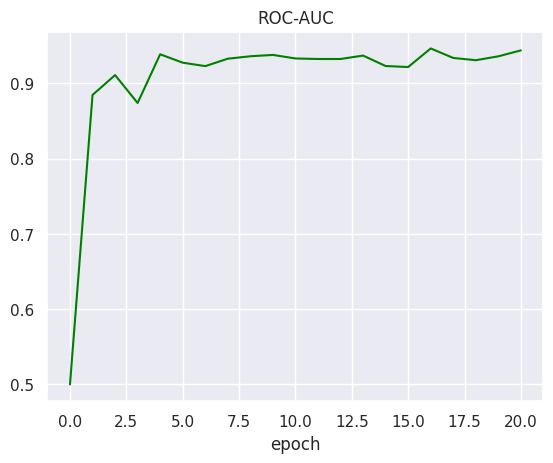

In [41]:
model = TokenLM(rnn_type = "lstm", hidden_dim=512, vocab_size=len(vocab), num_layers=2, dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters())
losses, acc, roc_auc = train_df(model, optimizer, criterion, num_epoch=7)
print(f"\nМинимальный Loss: {min(losses)}, Максимальный accuracy: {max(acc)}, Максимальный ROC AUC: {max(roc_auc)}")
visualize(losses, acc, roc_auc)

# Подготовка тестового датасета для разметки моделью

In [42]:
dataset_test = load_dataset('csv', data_files='/content/drive/MyDrive/Spam_classification/test_spam.csv', cache_dir='./')
# test = load_dataset('csv', data_files='/content/drive/MyDrive/ML Стажировки/Vk Spam/data/test_spam.csv', cache_dir='./')
# dataset = DatasetDict({
#     'train': train['train'],
#     'test': test['train']
# })
dataset_test

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 4070
    })
})

In [43]:
words = Counter()

for example in tqdm(dataset_test['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 50

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 4070/4070 [00:01<00:00, 2843.22it/s]

Размер словаря: 590


In [44]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences,
    }

    return new_batch

In [68]:
np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 4070)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [69]:
predictions = []
texts = []

model.eval()
with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            texts.append(batch['input_ids'])

predictions = torch.cat(predictions)

In [70]:
len(predictions)

4070

In [65]:
dataset_test = pd.read_csv('/content/drive/MyDrive/Spam_classification/test_spam.csv')
dataset_test.shape

(4070, 1)

In [71]:
dataset_test['text_type'] = 0

dataset_test['text_type'] = predictions.cpu()
dataset_test['text_type'] = dataset_test['text_type'].map({0 : 'ham', 1 : 'spam'})
dataset_test['text_type'].value_counts()

# Сохранение в CSV
dataset_test.to_csv('/content/drive/MyDrive/Spam_classification/classified_texts.csv', index=False)